# Recommendation 4: How to Separate Stimulus-locked Changes in Aperiodic Activity from ERPs


### Issue

Estimating time-resolved aperiodic activity during experimental tasks presents a similar challenge as any other event-locked analysis: when a stimulus is presented, there are potentially a lot of electrophysiological changes happening all at once! Event-related potentials (ERPs) are one fundamentally stimulus-locked phenomonen which might interact with stimulus-induced changes in oscillatory and aperiodic activities. How might we go about separating them?

### Solution

This is an ongoing and empirically open question. A few publications directly address this question (linked here), and here we summarize their approaches as well as a few others that we in the Voytek lab have been trying.

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [62]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import fooof

from neurodsp.sim import sim_combined, sim_knee, sim_peak_oscillation, sim_frac_gaussian_noise
from neurodsp.sim.transients import sim_damped_erp
from neurodsp.sim.utils import rotate_timeseries, rotate_spectrum
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [63]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [64]:
import seaborn as sns
sns.set_context('poster')

In [65]:
# Set random seed
set_random_seed(808)

In [66]:
# Set whether to save out figures
SAVE_FIG = False

### Demonstrating the problem: How can an ERP interact with changes in the Aperiodic Exponent?


#### Generate two timeseries: one from a pre-stimulus interval, and another from post-stimulus interval with a rotated power spectrum. Separately, generate an ERP

If you run the following code several times, you can see that the ERP has a variable effect on the post-stimulus aperiodic signal (e.g., comparing the orange and red line in the PSD plot).

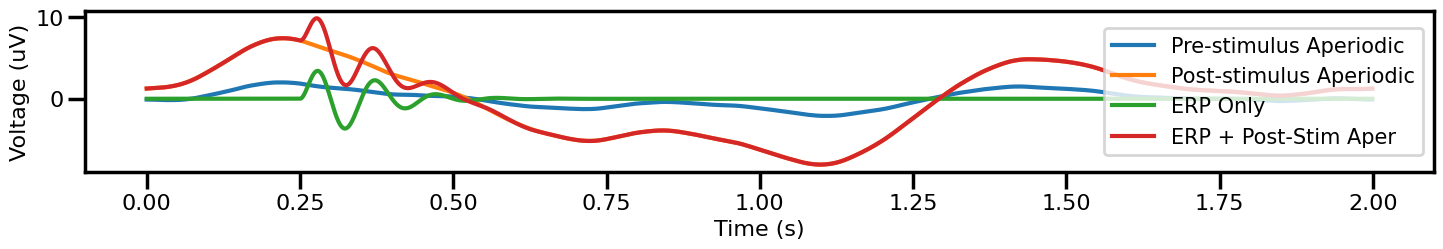

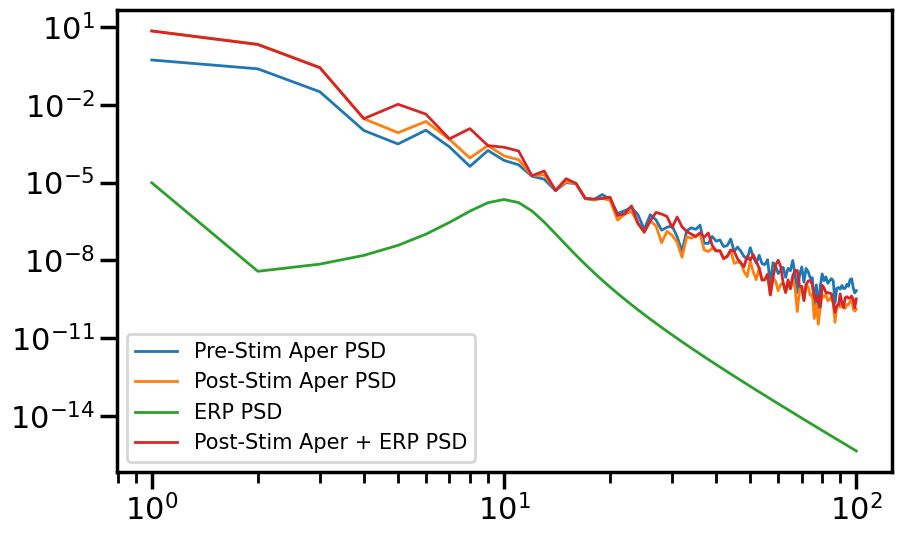

In [72]:
## Simulate timeseries as a combination of aperiodic and periodic components
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-5, 'knee':10},
                  }
fs = 1000
n_seconds = 2
ap_sig_pre = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
ap_sig_post = rotate_timeseries(ap_sig_pre, fs, delta_exp=1, f_rotation=15)
erp_sig = sim_damped_erp(n_seconds, fs, amp=4, freq=10, decay=0.05, time_start=0.25)
erp_plus_aper = ap_sig_post + erp_sig

# plot timeseries
times = create_times(n_seconds=n_seconds, fs=fs)
plot_time_series(times, [ap_sig_pre, ap_sig_post, erp_sig, erp_plus_aper], labels=['Pre-stimulus Aperiodic', 'Post-stimulus Aperiodic', 'ERP Only', 'ERP + Post-Stim Aper'])
plt.legend(loc = 'right', fontsize=15)
plt.show()

## Compute the power spectrum using Welch's 
freqs_pre, powers_pre = compute_spectrum(ap_sig_pre, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)
freqs_post, powers_post = compute_spectrum(ap_sig_post, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)
freqs_erp, powers_erp = compute_spectrum(erp_sig, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)
freqs_erp_plus, powers_erp_plus = compute_spectrum(erp_plus_aper, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)

fig,ax = plt.subplots(figsize=(10,6))
plt.loglog(freqs_pre,powers_pre, linewidth=2, label='Pre-Stim Aper PSD')
plt.loglog(freqs_post,powers_post, linewidth=2, label='Post-Stim Aper PSD')
plt.loglog(freqs_erp,powers_erp, linewidth=2, label= 'ERP PSD')
plt.loglog(freqs_erp_plus,powers_erp_plus, linewidth=2, label='Post-Stim Aper + ERP PSD')
plt.legend(loc='lower left',fontsize=15)
plt.show()

If we iterate through and simulate several "trials," we can try to recapitulate the approach of Gyurkovics et al 2022. In that paper, the authors generate a power spectrum from the trial-averaged ERP timeseries. They also generate pre- and post-stimulus window PSDs, from the timeseries of every trial. They then average those single-trial PSDs, and compare the average post-stimulus window PSD with the ERP-derived PSD. In doing so, they capture the effect of a time-domain phenomenon (the ERP) on the trial-averaged power spectrum.

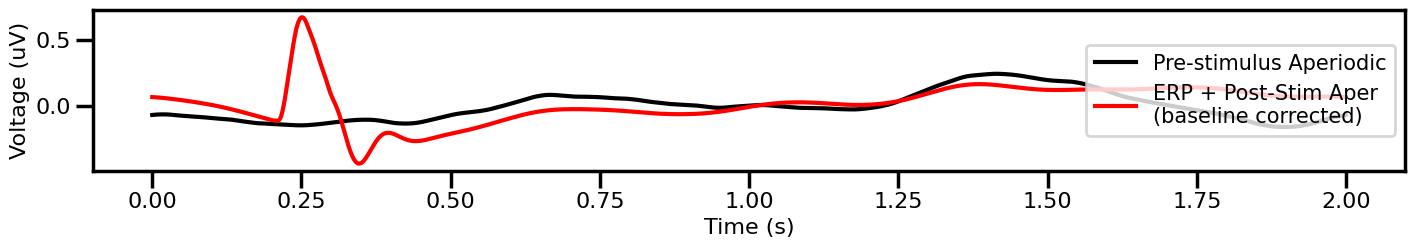

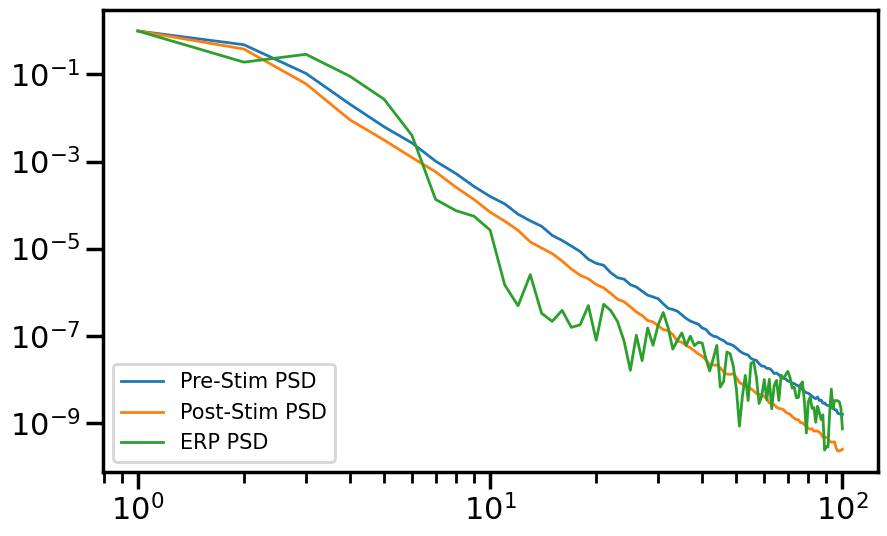

In [125]:
n_trials = 100

## Simulate timeseries as a combination of aperiodic and periodic components
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-5, 'knee':10},
                  }
fs = 1000
n_seconds = 2

pre_stim_aper = {'time':[], 'freqs':[], 'pows':[]}
post_stim_combined = {'time':[], 'freqs':[], 'pows':[]}
for t in range(n_trials):

    ap_shift = np.random.random() # randomize the degree of aperiodic change pre-to-post stim
    erp_amp = np.random.randint(low=1, high=5) # randomize ERP amplitude
    erp_latency = 0.25 + (np.random.randint(-50,50)/1000) #0.25 # jitter ERP start time
    #print(ap_shift, erp_amp, erp_latency)

    ## generate signals
    ap_sig_pre = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
    ap_sig_post = rotate_timeseries(ap_sig_pre, fs, delta_exp=ap_shift, f_rotation=15)
    erp_sig = sim_damped_erp(n_seconds, fs, amp=erp_amp, freq=10, decay=0.025, time_start=erp_latency)
    erp_plus_aper = ap_sig_post + erp_sig

    ## add the timeseries to our dictionary
    pre_stim_aper['time'].append(ap_sig_pre)
    post_stim_combined['time'].append(erp_plus_aper)

    ## Compute the power spectrum using Welch's 
    freqs_pre, powers_pre = compute_spectrum(ap_sig_pre, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)
    freqs_erp_plus, powers_erp_plus = compute_spectrum(erp_plus_aper, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)

    ## add the PSDs to the dictionary
    pre_stim_aper['freqs'].append(freqs_pre)
    post_stim_combined['freqs'].append(freqs_erp_plus)
    pre_stim_aper['pows'].append(powers_pre)
    post_stim_combined['pows'].append(powers_erp_plus)

## get the pre-stim window and post stim time windows, without averaging
pre_stim_sigs = (np.vstack(pre_stim_aper['time']))
post_stim_sigs = (np.vstack(post_stim_combined['time']))
## get pre-stim and post stim PSDs, with averaging
pre_stim_freqs =  np.mean(np.vstack(pre_stim_aper['freqs']), axis=0)
post_stim_freqs =  np.mean(np.vstack(post_stim_combined['freqs']), axis=0)
pre_stim_pows =  np.mean(np.vstack(pre_stim_aper['pows']), axis=0)
post_stim_pows =  np.mean(np.vstack(post_stim_combined['pows']), axis=0)

# do baseline correction of post-stimulus time signals, and then average these to get ERP
baseline_corr_erp = np.mean((post_stim_sigs - pre_stim_sigs), axis=0) 
# calculate PSD of ERP
freqs_erp, powers_erp = compute_spectrum(baseline_corr_erp, fs=fs, f_range=(0.1,100), avg_type='median', nperseg=fs, noverlap=fs/2)

# plot timeseries
times = create_times(n_seconds=n_seconds, fs=fs)
plot_time_series(times, [np.mean(pre_stim_sigs, axis=0), baseline_corr_erp], labels=['Pre-stimulus Aperiodic', 'ERP + Post-Stim Aper \n(baseline corrected)'])
plt.legend(loc = 'right', fontsize=15)
plt.show()

# plot power spectra, with pivot freq of 15Hz
fig,ax = plt.subplots(figsize=(10,6))
plt.loglog(pre_stim_freqs,(pre_stim_pows/pre_stim_pows[0]), linewidth=2, label='Pre-Stim PSD')
plt.loglog(post_stim_freqs,(post_stim_pows/post_stim_pows[0]), linewidth=2, label='Post-Stim PSD')
plt.loglog(freqs_erp,(powers_erp/powers_erp[0]), linewidth=2, label= 'ERP PSD')
#plt.loglog(freqs_erp_plus,powers_erp_plus, linewidth=2, label='Post-Stim Aper + ERP PSD')
plt.legend(loc='lower left',fontsize=15)
plt.show()

### SECTION II TITLE

### Conclusion

<>